# 함수 선언 및  import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import sklearn
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import KFold

import random as rn

RANDOM_SEED = 2023
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)



from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

개발 환경(OS): Windows 10 Pro, 64비트 운영 체제

In [2]:
print("pandas version: {}". format(pd.__version__))
print("NumPy version: {}". format(np.__version__))
print("scikit-learn version: {}". format(sklearn.__version__))
print("matplotlib version: {}". format(matplotlib.__version__))
print("seaborn version: {}". format(sns.__version__))
print("XGBoost version: {}". format(xgboost.__version__))

pandas version: 2.2.3
NumPy version: 2.3.2
scikit-learn version: 1.7.1
matplotlib version: 3.10.5
seaborn version: 0.13.2
XGBoost version: 1.7.6


In [3]:
def smape(gt, preds):
    gt= np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score

In [4]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [5]:
def custom_smape(preds, dtrain):
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

# 데이터 전처리

## 데이터 불러오기

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
building_info = pd.read_csv('building_info.csv')

In [7]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [8]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [9]:
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

In [10]:
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity !='-',1,0)
building_info['ess_utility'] = np.where(building_info.ess_capacity !='-',1,0)

In [11]:
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

## 결측치 확인 및 보간

In [12]:
train.isna().sum()

building_number         0
date_time               0
temperature             0
rainfall                0
windspeed               0
humidity                0
sunshine                0
solar_radiation         0
power_consumption       0
building_type           0
total_area              0
cooling_area            0
solar_power_capacity    0
ess_capacity            0
pcs_capacity            0
solar_power_utility     0
ess_utility             0
dtype: int64

In [13]:
train.solar_power_capacity.value_counts()

solar_power_capacity
-          95880
278.58      2040
1983.05     2040
389.76      2040
217.92      2040
1349.03     2040
276         2040
849.78      2040
1974.71     2040
97          2040
100         2040
255.88      2040
879.82      2040
858.02      2040
953.4       2040
83.95       2040
97.85       2040
344.96      2040
342         2040
12.24       2040
83.2        2040
74.25       2040
140.6       2040
77.76       2040
198.56      2040
10.08       2040
218.88      2040
1039.86     2040
105         2040
215.89      2040
1397.02     2040
199.4       2040
219.6       2040
820         2040
540.57      2040
50.88       2040
94.38       2040
1297.98     2040
1340.1      2040
103         2040
419.2       2040
36          2040
790.08      2040
605         2040
495         2040
282.95      2040
38.88       2040
77.38       2040
168         2040
322.9       2040
99.64       2040
20.25       2040
81.38       2040
171.6       2040
Name: count, dtype: int64

In [14]:
train.ess_capacity.value_counts()

ess_capacity
-        179520
2000       4080
101.5      2040
1025       2040
500        2040
3100       2040
205        2040
469.2      2040
1670       2040
150        2040
201.1      2040
209        2040
Name: count, dtype: int64

In [15]:
train.pcs_capacity.value_counts()

pcs_capacity
-       179520
101       4080
1000      4080
500       4080
250       2040
1500      2040
150       2040
550       2040
75        2040
100       2040
Name: count, dtype: int64

In [16]:
train['windspeed']= train.windspeed.interpolate()
train['humidity']= train.humidity.interpolate()

## Datetime 분리

In [17]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['day_of_week'] = train['date_time'].dt.dayofweek #요일


test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['day_of_week'] = test['date_time'].dt.dayofweek #요일

## Feature Engineering

### 평균기온, 최대기온 변수

In [18]:
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    result_dict = {}

    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)

    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value

    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]

    
train['day_max_temperature'] = 0.0
train['day_mean_temperature'] = 0.0

calculate_day_values(train, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(train, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(train, 'temperature', 'day_min_temperature', 'min')

train['day_temperature_range'] = train['day_max_temperature'] - train['day_min_temperature']

calculate_day_values(test, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(test, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(test, 'temperature', 'day_min_temperature', 'min')

test['day_temperature_range'] = test['day_max_temperature'] - test['day_min_temperature']


### Outlier drop

In [19]:
outlier_list = [68973,71013,112384,123132,150739,150740,150741,150742,
                150883,150884,150885,150886,138904,193120,193121,152393]

train.drop(outlier_list, axis=0,inplace=True)

### 임시 휴무 추측 데이터 drop

In [ ]:
# temp_hol = {2 : ['2022-06-17'], 
#     5 : ['2022-07-25','2022-08-02','2022-08-09','2022-08-16'],
#     11 : ['2022-06-17'], 12 : ['2022-07-02'], 17 : ['2022-06-18','2022-07-25'],
#     21 : ['2022-07-01','2022-07-03','2022-07-17','2022-07-30'], 
#     37 : ['2022-06-20','2022-07-11','2022-08-08'], 
#     38 : ['2022-06-13','2022-07-25','2022-08-01'],
#     39 : ['2022-07-18','2022-08-08'],
#     40 : ['2022-06-20','2022-07-18','2022-08-08'],
#     41 : ['2022-06-27','2022-07-25','2022-08-08'],
#     42 : ['2022-06-13','2022-07-11','2022-08-22'],
#     54 : ['2022-08-16','2022-08-17'],74 : ['2022-06-03'],
#     75 : ['2022-06-15','2022-06-17','2022-06-20','2022-06-21'],
#     86 : ['2022-06-10','2022-08-10'],
#     89 : ['2022-07-09'], 91 : ['2022-06-13','2022-07-11','2022-08-22','2022-06-08'], 92 : ['2022-07-30']}


# mask = train.apply(lambda x: x['building_number'] in temp_hol and str(x['date_time'])[:10] in temp_hol[x['building_number']], axis=1)

# train.drop(train[mask].index, axis=0, inplace=True)

# train.reset_index(drop=True, inplace=True)

### 공휴일변수

In [21]:
holi_weekday = [
    '2024-06-06',  # 현충일 (목)
    '2024-08-15'   # 광복절 (목)
]

train['holiday'] = np.where((train.day_of_week >= 5) | (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)
test['holiday'] = np.where((test.day_of_week >= 5) | (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

### 대형마트 휴무일요일 변수

In [22]:
holi_sun = [
    '2024-06-09', '2024-06-23',  # 6월
    '2024-07-14', '2024-07-28',  # 7월
    '2024-08-11', '2024-08-25'   # 8월
]

# 의무 휴업 일요일이면 1, 아니면 0
train['Sunday_holiday'] = np.where((train.day_of_week == 6) & (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_sun)), 1, 0)
test['Sunday_holiday'] = np.where((test.day_of_week == 6) & (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_sun)), 1, 0)

### 시간변수 푸리에변환

In [23]:
#시간
train['sin_hour'] = np.sin(2 * np.pi * train['hour']/23.0)
train['cos_hour'] = np.cos(2 * np.pi * train['hour']/23.0)
test['sin_hour'] = np.sin(2 * np.pi * test['hour']/23.0)
test['cos_hour'] = np.cos(2 * np.pi * test['hour']/23.0)

#날짜
train['sin_date'] = -np.sin(2 * np.pi * (train['month']+train['day']/31)/12)
train['cos_date'] = -np.cos(2 * np.pi * (train['month']+train['day']/31)/12)
test['sin_date'] = -np.sin(2 * np.pi * (test['month']+test['day']/31)/12)
test['cos_date'] = -np.cos(2 * np.pi * (test['month']+test['day']/31)/12)

#월
train['sin_month'] = -np.sin(2 * np.pi * train['month']/12.0)
train['cos_month'] = -np.cos(2 * np.pi * train['month']/12.0)
test['sin_month'] = -np.sin(2 * np.pi * test['month']/12.0)
test['cos_month'] = -np.cos(2 * np.pi * test['month']/12.0)

#요일
train['sin_dayofweek'] = -np.sin(2 * np.pi * (train['day_of_week']+1)/7.0)
train['cos_dayofweek'] = -np.cos(2 * np.pi * (train['day_of_week']+1)/7.0)
test['sin_dayofweek'] = -np.sin(2 * np.pi * (test['day_of_week']+1)/7.0)
test['cos_dayofweek'] = -np.cos(2 * np.pi * (test['day_of_week']+1)/7.0)

### CDH(냉방도시) 변수

In [24]:
def CDH(xs):
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

### THI(불쾌지수) 변수

In [25]:
train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

test['THI'] = 9/5*test['temperature'] - 0.55*(1-test['humidity']/100)*(9/5*test['humidity']-26)+32

### WCT(체감온도) 변수

In [26]:
train['WCT'] = 13.12 + 0.6125*train['temperature'] - 11.37*(train['windspeed']**
                                                            0.16) + 0.3965*(train['windspeed']**0.16)*train['temperature']
test['WCT'] = 13.12 + 0.6125*test['temperature'] - 11.37*(test['windspeed']**
                                                            0.16) + 0.3965*(test['windspeed']**0.16)*test['temperature']

### 전력소비 통계량 변수

In [27]:
# Calculate 'day_hour_mean'
power_mean = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour', 'day_of_week'], aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

# Calculate 'day_hour_std'
power_std = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour', 'day_of_week'], aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# Calculate 'hour_mean'
power_hour_mean = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour'], aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

# Calculate 'hour_std'
power_hour_std = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour'], aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# Merge calculated features to 'train' and 'test' dataframes
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')

train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')

train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')

train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)

# 모델링

## X,Y,test 선언

In [28]:
X = train.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity',
                'power_consumption','rainfall', 'sunshine', 'solar_radiation',
                'hour','day','month','day_of_week','date_time'],axis =1 )

Y = train[['building_type','power_consumption']]

test_X = test.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity','rainfall',
                   'hour','month','day_of_week','day','date_time'], axis=1)

In [29]:
type_list = []
for value in train.building_type.values:
    if value not in type_list:
        type_list.append(value)

## XGB 건물 유형별 단일모델

In [45]:
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

# 데이터 준비 (현재 X, y는 train 데이터 기반으로 세팅되어 있다고 가정)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED
)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 6),
        'tree_method': 'gpu_hist',  # GPU 빠른 학습
        'random_state': RANDOM_SEED
    }

    model = XGBRegressor(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=False
    )
    preds = model.predict(X_valid)
    return smape(y_valid, preds)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)  # 빠른 탐색
print("Best Params:", study.best_params)


ValueError: Found input variables with inconsistent numbers of samples: [203984, 16320]

In [31]:
xgb_best_params = pd.read_csv('xgb_best_params_found.csv')
xgb_best_params['building_type'] = type_list
xgb_best_params.set_index('building_type',inplace=True)

In [32]:
xgb_best_params

,Unnamed: 0,max_bin,eta,max_depth,min_child_weight,subsample,colsample_bytree,reg_lambda,reg_alpha,alpha
building_type,,,,,,,,,,
호텔,호텔,299,0.171359,4,4,0.704673,0.880432,5.822530e-06,2.698564e-06,1.329574
Commercial,Commercial,383,0.141605,9,12,0.810131,0.983139,4.324914e-01,2.013676e-04,0.661304
Hospital,Hospital,337,0.141396,5,2,0.898258,0.988039,9.927880e-08,4.867693e-04,1.026727
학교,학교,208,0.010676,4,8,0.726598,0.931666,1.910671e-01,8.421429e+00,1.788165
Other Buildings,Other Buildings,259,0.196236,3,1,0.714305,0.792578,1.561624e-03,2.851216e-02,0.763867
Apartment,Apartment,262,0.100000,6,2,0.800000,0.800000,1.000000e+00,1.000000e-08,1.000000
Research Institute,Research Institute,361,0.124921,6,9,0.607584,0.946348,1.568387e-02,7.455931e-03,1.175714
백화점,백화점,301,0.149205,4,6,0.713816,0.991798,1.849544e-05,6.786033e-03,0.952556
IDC(전화국),IDC(전화국),272,0.023924,8,3,0.705876,0.650179,5.562524e-03,1.268305e-01,1.519085


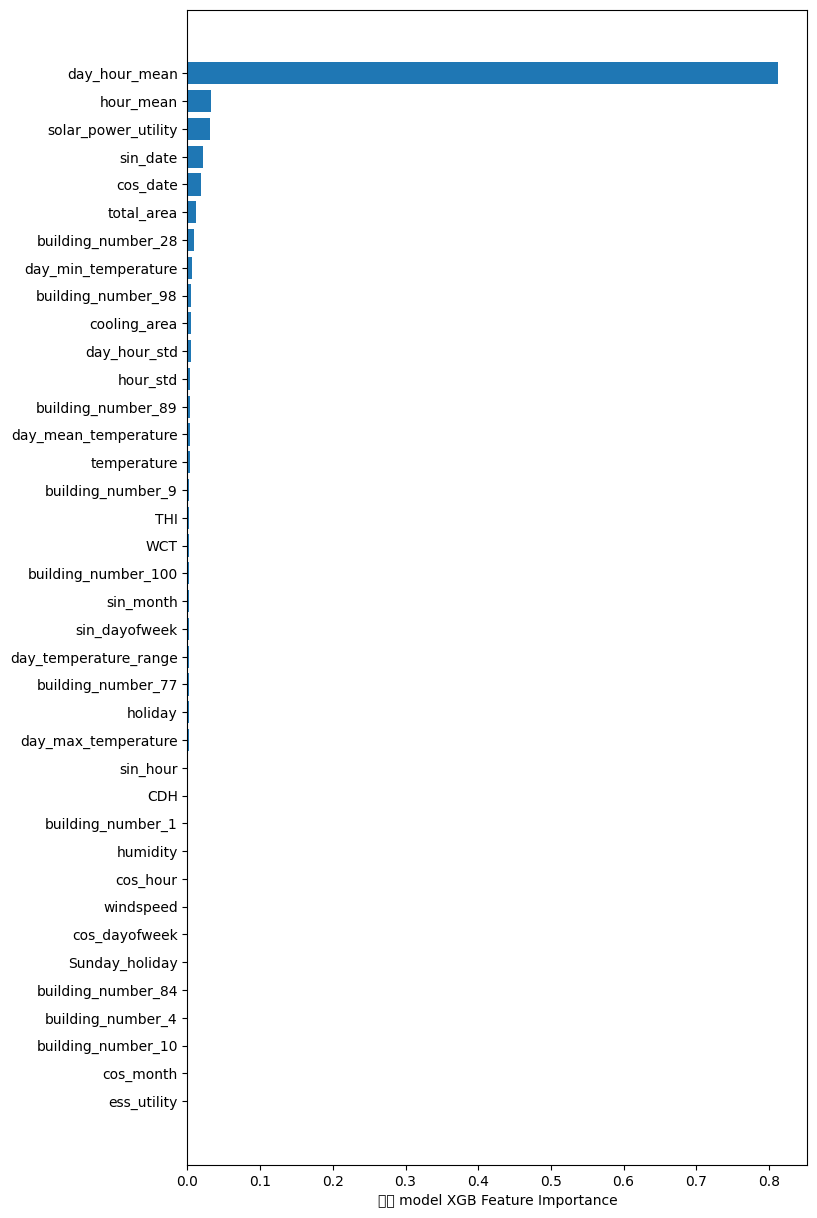

Building type = 호텔 : XGBRegressor Model SMAPE : 5.2125


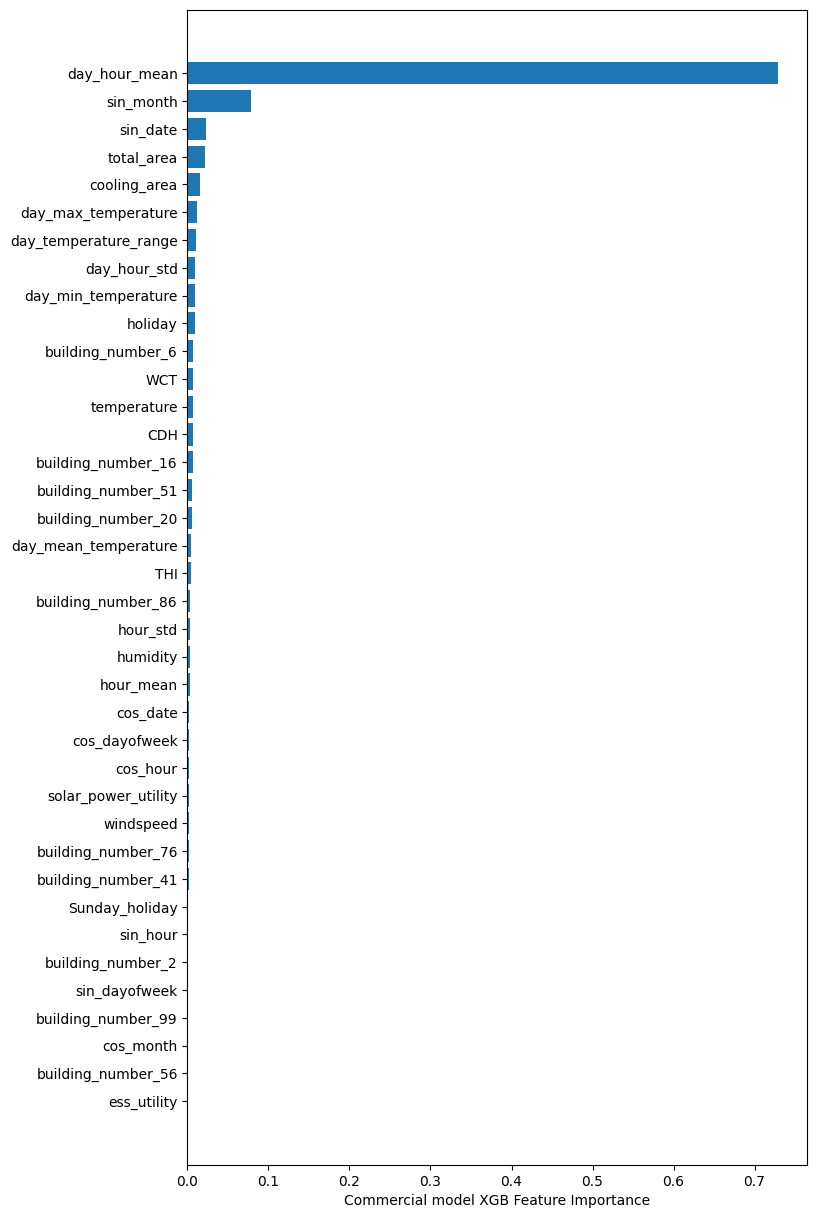

Building type = Commercial : XGBRegressor Model SMAPE : 2.2326


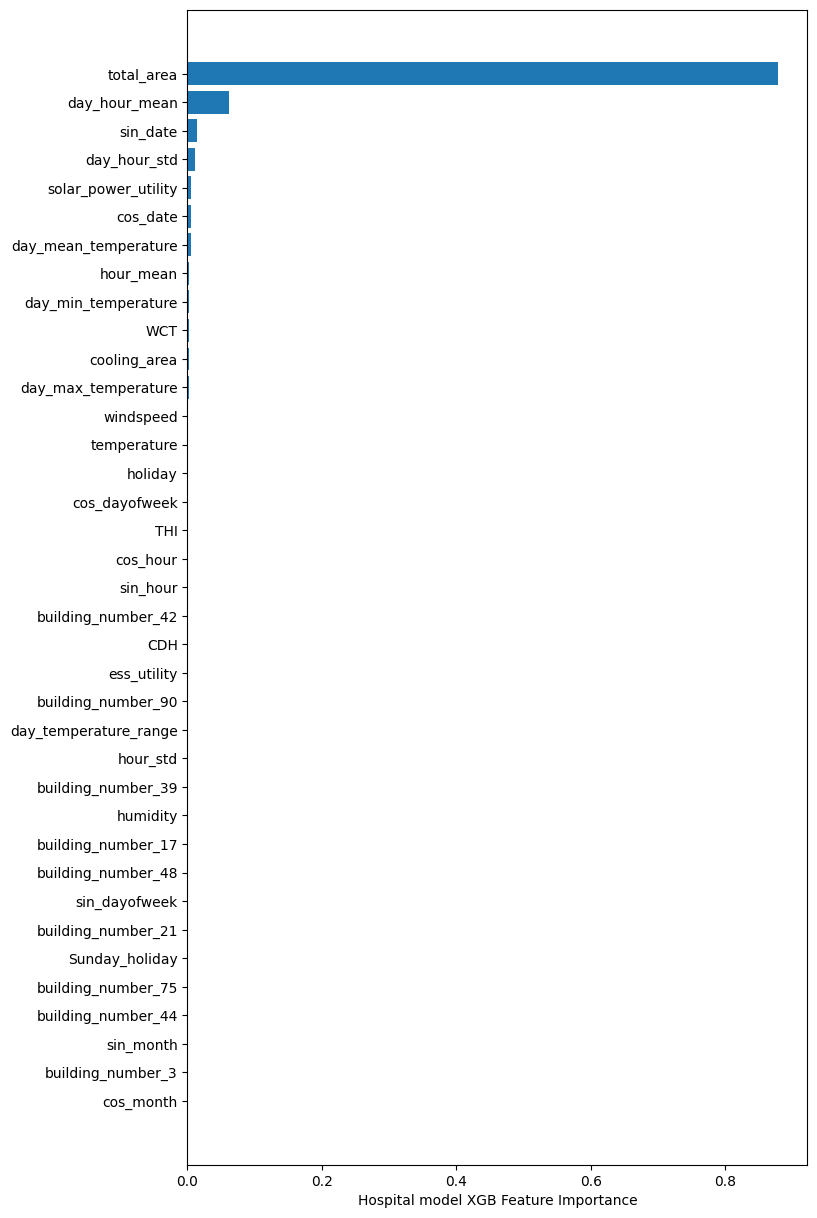

Building type = Hospital : XGBRegressor Model SMAPE : 2.7337


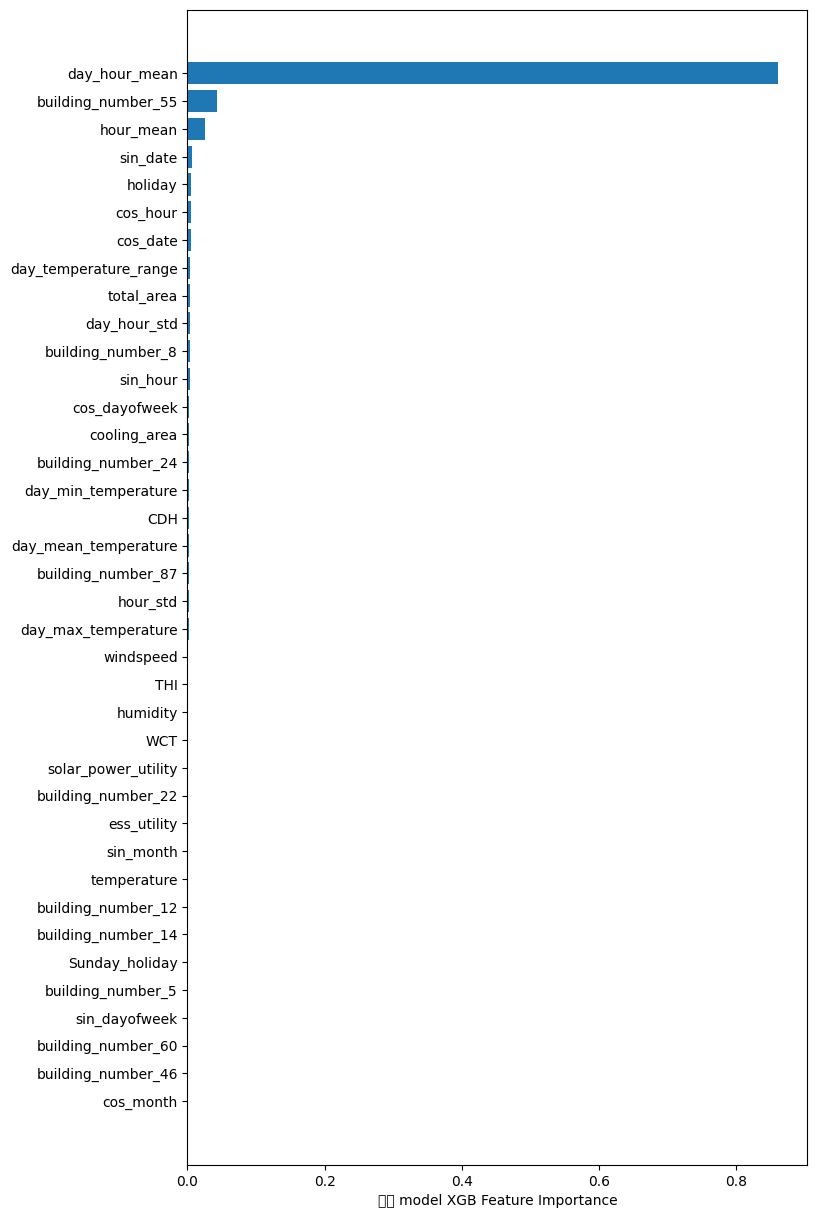

Building type = 학교 : XGBRegressor Model SMAPE : 2.6787


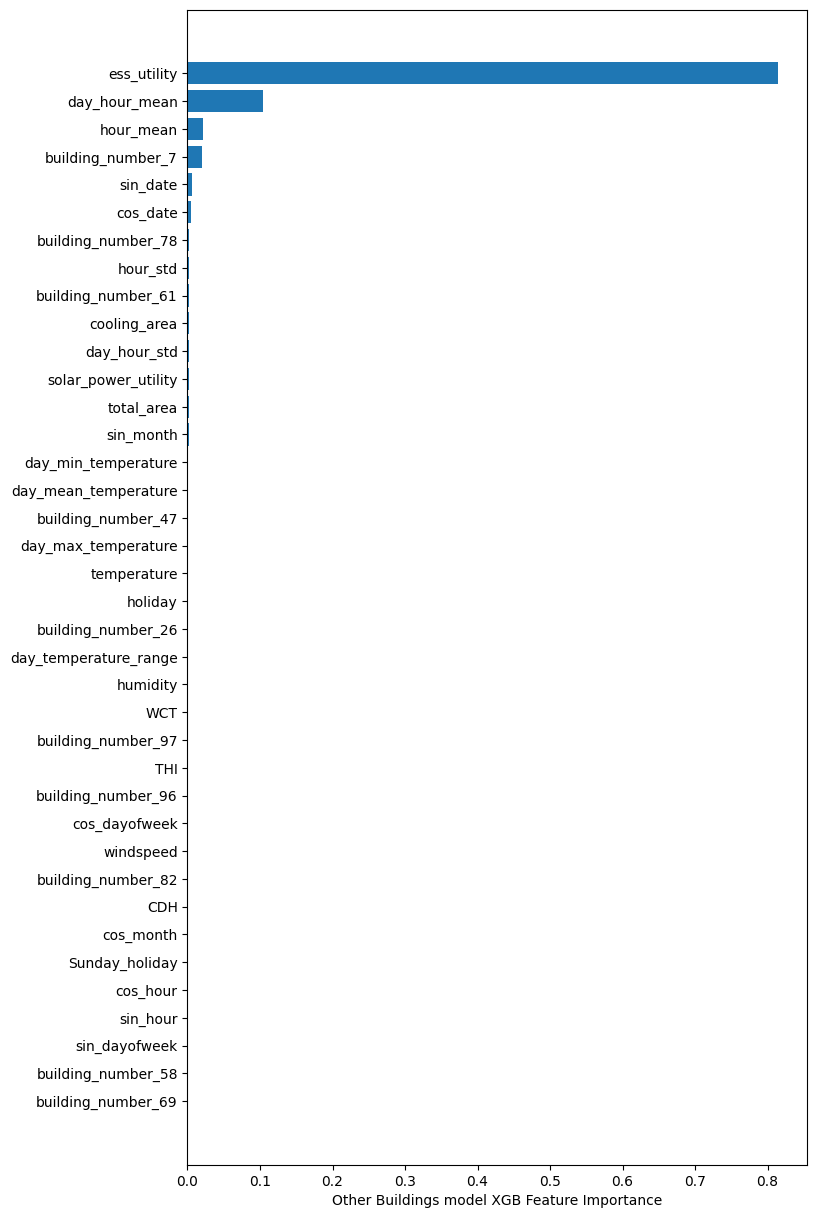

Building type = Other Buildings : XGBRegressor Model SMAPE : 5.0944


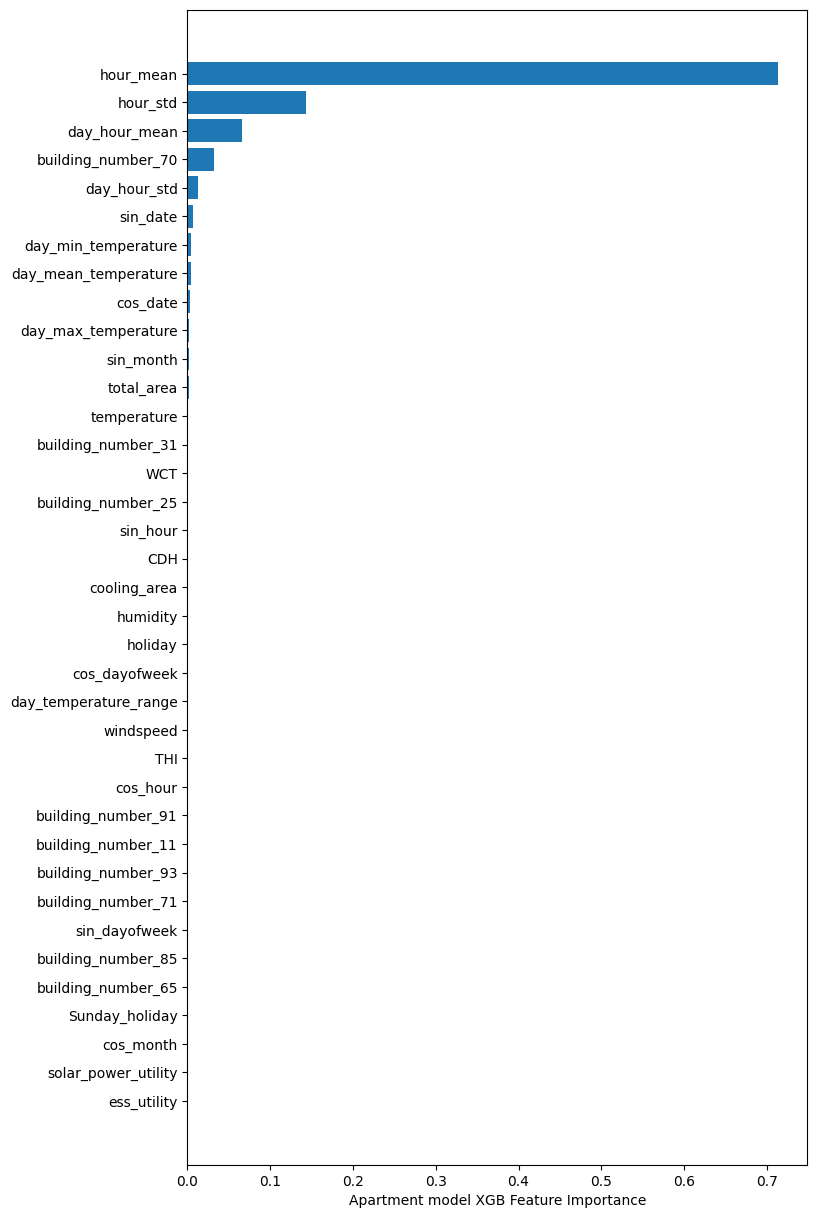

Building type = Apartment : XGBRegressor Model SMAPE : 3.2732


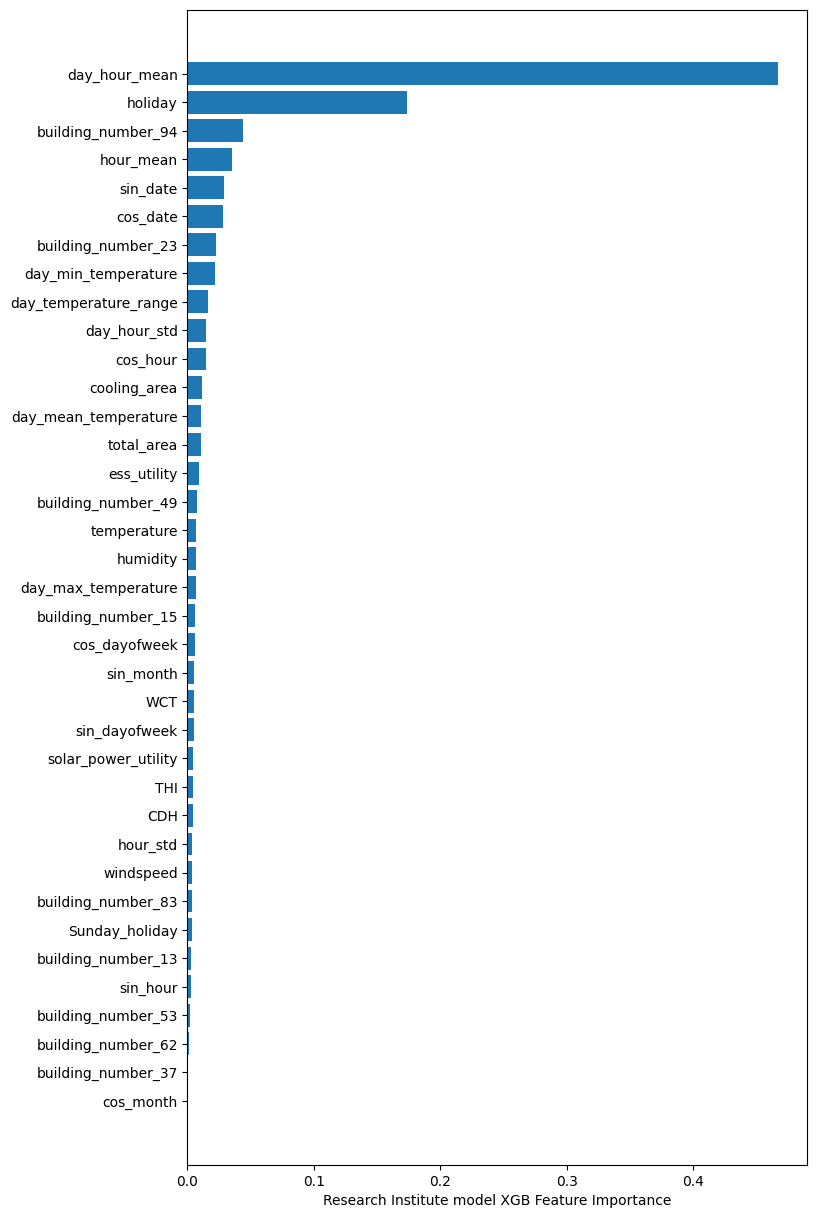

Building type = Research Institute : XGBRegressor Model SMAPE : 3.5356


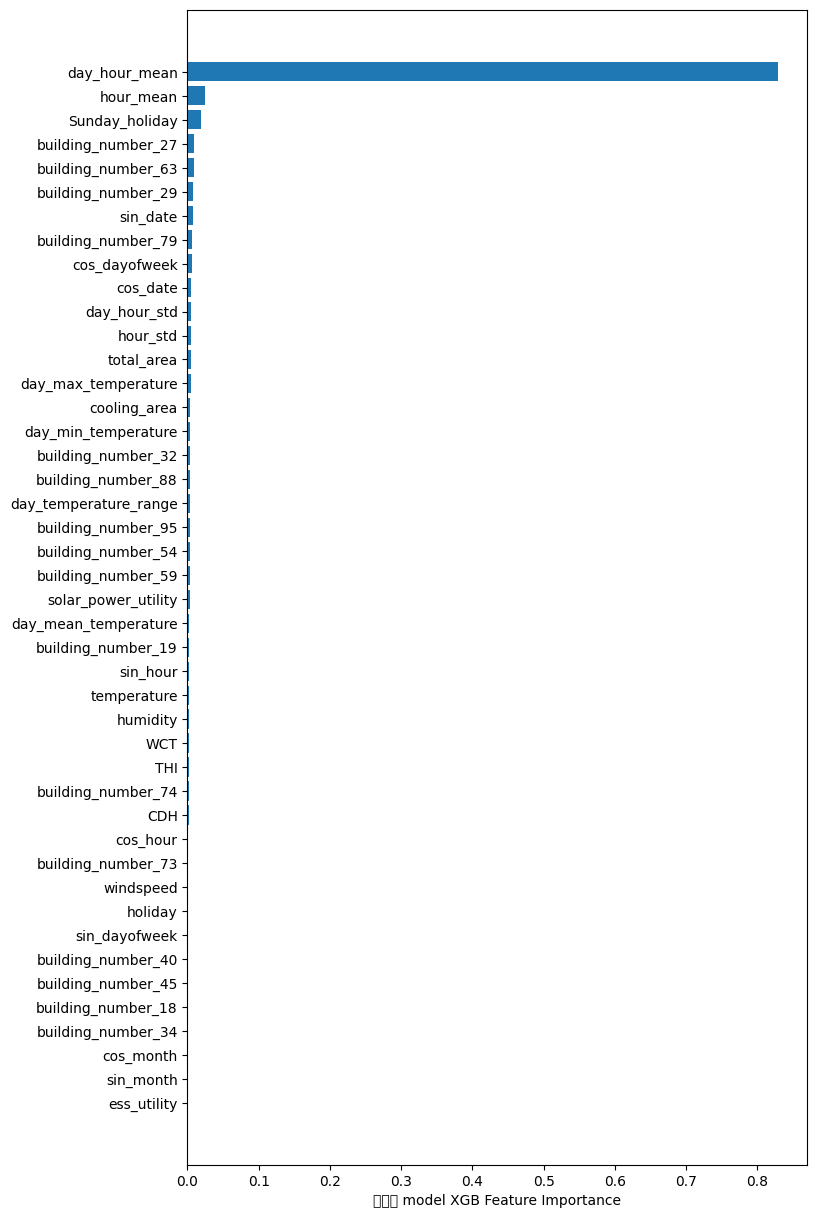

Building type = 백화점 : XGBRegressor Model SMAPE : 4.6758


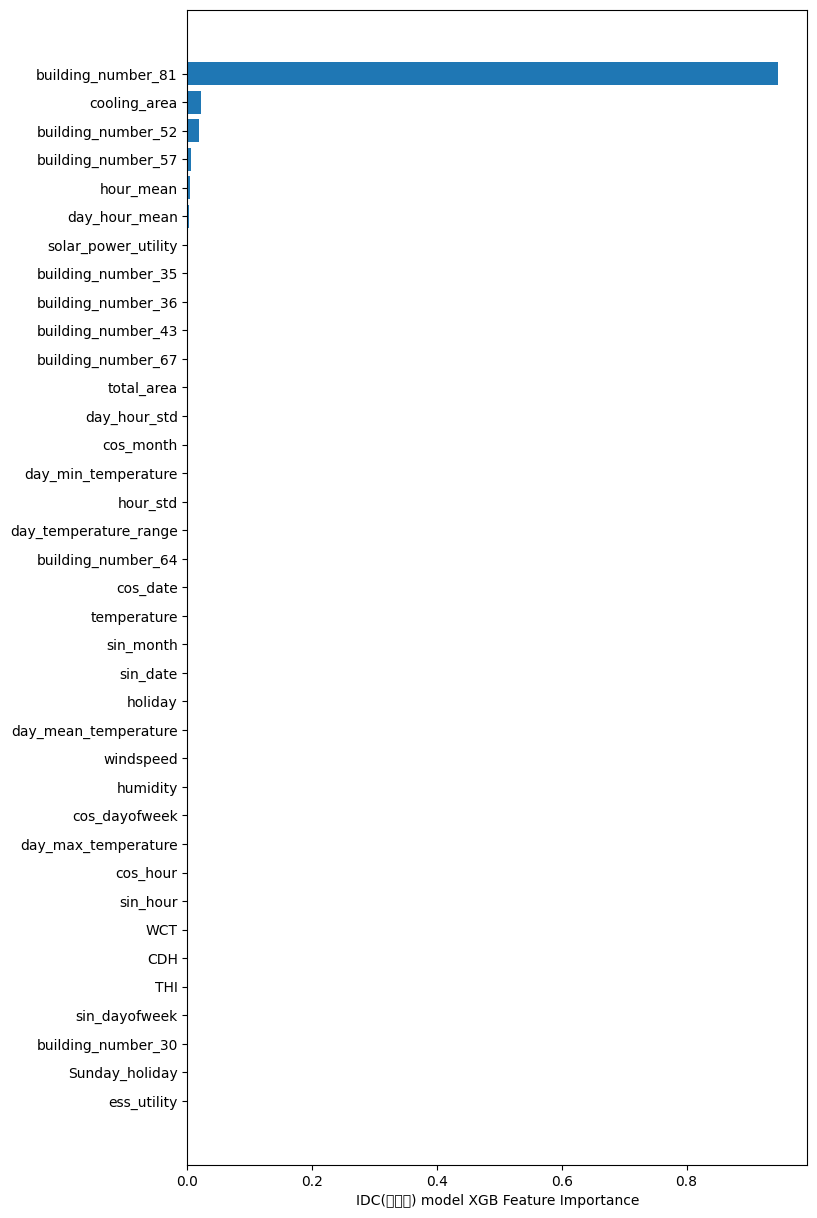

Building type = IDC(전화국) : XGBRegressor Model SMAPE : 0.9524


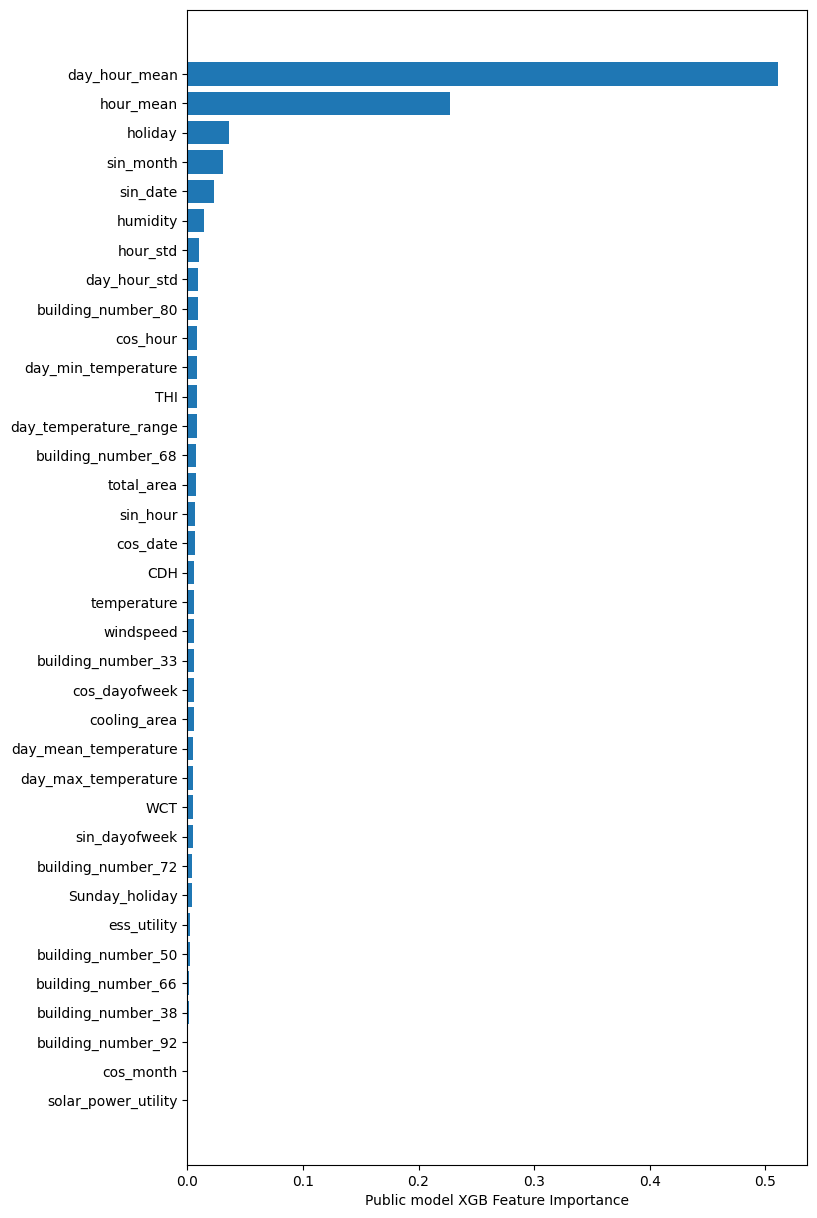

Building type = Public : XGBRegressor Model SMAPE : 5.7724
Total SMAPE : 88.8058


In [36]:
kf = KFold(n_splits=7, shuffle=True, random_state=RANDOM_SEED)
answer_df = pd.DataFrame(columns=['answer'])
pred_df   = pd.DataFrame(columns=['pred'])

for i in type_list:
    # --- 데이터 준비 ---
    x = X[X.building_type == i].copy()
    y = Y[Y.building_type == i]['power_consumption'].astype(float).copy()
    X_test = test_X[test_X.building_type == i].copy()

    # 원핫
    x = pd.get_dummies(x, columns=['building_number'], drop_first=False)
    X_test = pd.get_dummies(X_test, columns=['building_number'], drop_first=False)

    # 불필요 컬럼 제거 (있을 때만)
    for df_ in (x, X_test):
        if 'building_type' in df_.columns:
            df_.drop(columns=['building_type'], inplace=True)

    # (중요) train/test 더미 컬럼 **정렬/맞춤**
    x, X_test = x.align(X_test, join='outer', axis=1, fill_value=0)

    # 피처 NaN/Inf 가드
    x = x.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(0)

    # 이후 참조용 컬럼명
    x_columns = np.array(x.columns)

    # numpy 변환
    x = x.values.astype(np.float32)
    y = y.values.astype(np.float32)

    j = 0
    xgb_fold_smape = []
    answer_list = []
    pred = pd.DataFrame(index=range(0, y.shape[0]), columns=['pred'])

    for train_index, valid_index in kf.split(x):
        j += 1

        X_train, X_valid = x[train_index], x[valid_index]
        Y_train, Y_valid = y[train_index], y[valid_index]

        # (중요) 라벨 안전 로그 변환
        # 0 이하를 방어하고 log1p 사용 -> 역변환은 expm1
        Y_train_t = np.log1p(np.clip(Y_train, a_min=0, a_max=None))
        Y_valid_t = np.log1p(np.clip(Y_valid, a_min=0, a_max=None))

        # 혹시 남아있는 비정상값 제거
        tr_mask = np.isfinite(Y_train_t)
        va_mask = np.isfinite(Y_valid_t)
        if not tr_mask.all():
            X_train, Y_train_t = X_train[tr_mask], Y_train_t[tr_mask]
        if not va_mask.all():
            X_valid, Y_valid_t = X_valid[va_mask], Y_valid_t[va_mask]

        evals = [(X_train, Y_train_t), (X_valid, Y_valid_t)]

        xgb_model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=int(xgb_best_params.loc[i]['max_depth']),
            random_state=RANDOM_SEED,
            subsample=xgb_best_params.loc[i]['subsample'],
            colsample_bytree=xgb_best_params.loc[i]['colsample_bytree'],
            min_child_weight=int(xgb_best_params.loc[i]['min_child_weight']),
            objective=weighted_mse(xgb_best_params.loc[i]['alpha']),
            tree_method='gpu_hist', 
        )

        xgb_model.fit(
            X_train, Y_train_t,
            early_stopping_rounds=100,
            eval_metric=custom_smape,   # 커스텀 메트릭 시그니처가 xgb 규약에 맞는지 확인
            eval_set=evals,
            verbose=False
        )

        # 검증 예측 (역변환은 expm1)
        xgb_pred_t = xgb_model.predict(X_valid)
        xgb_pred = np.expm1(xgb_pred_t)
        pred.loc[valid_index, 'pred'] = xgb_pred

        # SMAPE는 원스케일(y)에서 계산
        xgb_smape = smape(Y_valid, xgb_pred)
        xgb_fold_smape.append(xgb_smape)

        # 테스트 예측
        xgb_answer_t = xgb_model.predict(X_test.values.astype(np.float32))
        answer_list.append(np.expm1(xgb_answer_t))

        # 마지막 폴드에서 중요도 그리기
        if j == kf.n_splits:
            sorted_idx = xgb_model.feature_importances_.argsort()
            plt.figure(figsize=(8, 15))
            plt.barh(x_columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
            plt.xlabel(f'{i} model XGB Feature Importance')
            plt.show()

    type_answer = sum(answer_list) / len(answer_list)

    answer = pd.DataFrame({'answer': type_answer})
    answer_df = pd.concat([answer_df, answer], ignore_index=True)
    pred_df = pd.concat([pred_df, pred], ignore_index=True)

    avg_smape = sum(xgb_fold_smape) / len(xgb_fold_smape)
    print('Building type = %s : XGBRegressor Model SMAPE : %.4f' % (i, avg_smape))

total_score = smape(Y.power_consumption.values, pred_df.pred.values.astype(float))
print('Total SMAPE : %.4f' % (total_score))


## 정답파일 만들기

In [41]:
answer = pd.read_csv('sample_submission.csv')

In [42]:
answer.answer = answer_df.answer

In [43]:
answer.to_csv('submission.csv',index = False)

In [44]:
answer.head()

,num_date_time,answer
0,1_20240825 00,4384.932617
1,1_20240825 01,4494.730469
2,1_20240825 02,3899.021729
3,1_20240825 03,3550.336426
4,1_20240825 04,3359.515625
